# Model Interpretation for ResNet

This notebook applies model interpretability algorithms on pretrained deep learning models (in this case ResNet 50 or 101), using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image. It was provided by Captum Library. 
The originally used approoaches were: <br>
`Integrated Gradients` (w/ and w/o noise tunnel),  
`GradientShap`, <br>
`Occlusion`, <br>
`LRP`. <br>
Since the latter is not compatible with ResNet, it was substituted by a modified version of `LIME`, also from the Captum Library.

## Import necessary libraries

**Note** modify the path to the folder CNN_classifier with your own.


In [56]:
import sys
sys.path.append('/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier') #modify with own path to the folder CNN_classifier

In [57]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision
from torchvision import models
from torchvision import transforms

from PIL import Image

#import os
#import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import Lime #LimeBase
from captum.attr import visualization as viz
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum.attr._core.lime import Lime
from captum.attr._core.lime import get_exp_kernel_similarity_function
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic


from CNN_classifier.cub import cub200
from CNN_classifier.models.models_for_cub import ResNet

## Loading the model and the dataset


Load the Resnet model we trained on CUB and sets it to eval mode. <br> 

Please modify `model_choice` to =101 if you want to use ResNet 101 and the path to the saved model on `checkpoint_path` with the model you want to use.

In [58]:
#initialize ResNet for CUB-200-2011
model = ResNet(pre_trained=False, n_class=200, model_choice=50) #if using ResNet101 modify model_choice

#load the trained weights
checkpoint_path = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier/model_save1/ResNet/ResNet/ResNet50.pkl"  #replace with your model's file path
state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))

#remove `module.` prefix if present in the keys
if any(key.startswith("module.") for key in state_dict.keys()):
    state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

#load the state_dict into the model
model.load_state_dict(state_dict)

#set the model to evaluation mode
model = model.eval()

print("Loaded ResNet trained on CUB-200-2011.")

/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/MLNLP/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/MLNLP/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1113543/1374610044.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

Loaded ResNet trained on CUB-200-2011.


Please modify the `classes_file_path` with the path to the classes contained int CUB_200_2011/classes.txt

In [59]:
#define the path to the classes.txt file
classes_file_path = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier/CUB_200_2011/classes.txt"  #replace with actual path

#load the CUB-200-2011 class labels into a dictionary
idx_to_labels = {}
with open(classes_file_path, "r") as file:
    for line in file:
        class_id, class_name = line.strip().split(" ")
        idx_to_labels[int(class_id) - 1] = class_name  

#print some labels (5) to verify the procedure
print(f"Loaded {len(idx_to_labels)} class labels for CUB-200-2011.")
print(f"Sample labels: {list(idx_to_labels.items())[:5]}")

Loaded 200 class labels for CUB-200-2011.
Sample labels: [(0, '001.Black_footed_Albatross'), (1, '002.Laysan_Albatross'), (2, '003.Sooty_Albatross'), (3, '004.Groove_billed_Ani'), (4, '005.Crested_Auklet')]


Define transformers and normalizing functions for the image. <br>
Then load an image from the CUB folder that will be used for interpretation.      
Please add a path in `image_path` to a photo of your choice from the dataset (CUB_200_2011/images/selected_pic)

Input tensor shape: torch.Size([1, 3, 448, 448])


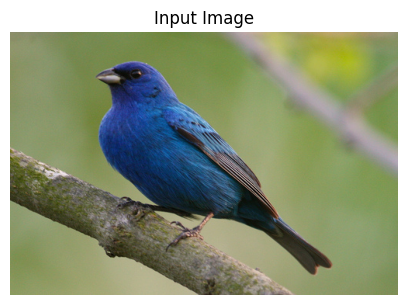

In [60]:
transform = transforms.Compose([
 transforms.Resize(448), #modified from 226 in the original code
 transforms.CenterCrop(448), #modified from 226 in the original code
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

image_path = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet_backup/modifica_resnet/CNN_classifier/CUB_200_2011/images/014.Indigo_Bunting/Indigo_Bunting_0010_13000.jpg"
img = Image.open(image_path).convert("RGB")

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

print(f"Input tensor shape: {input.shape}") #final check to show the tensor shape

#display the original image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Input Image")
plt.show()


Predict the class of the input image

In [61]:
#pass the input through the model
output = model(input)

#apply softmax to get class probabilities
output = F.softmax(output, dim=1)

#get the highest prediction score and its index
prediction_score, pred_label_idx = torch.topk(output, 1)

#convert the index to a label
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[pred_label_idx.item()]  #use idx_to_labels loaded from classes.txt

print(f'Best prediction: {predicted_label} (Confidence: {prediction_score.squeeze().item():.4f})')

#look for best five predictions
top5_scores, top5_indices = torch.topk(output, 5)

#convert indices to labels
top5_labels = [idx_to_labels[idx.item()] for idx in top5_indices.squeeze()]

print("\nTop 5 predictions:")
for i in range(5):
    print(f"{i+1}. {top5_labels[i]} (Confidence: {top5_scores.squeeze()[i].item():.4f})")


Best prediction: 014.Indigo_Bunting (Confidence: 0.9678)

Top 5 predictions:
1. 014.Indigo_Bunting (Confidence: 0.9678)
2. 015.Lazuli_Bunting (Confidence: 0.0158)
3. 054.Blue_Grosbeak (Confidence: 0.0069)
4. 134.Cape_Glossy_Starling (Confidence: 0.0054)
5. 016.Painted_Bunting (Confidence: 0.0034)


## 1- Gradient-based attribution

The approach computes attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to the input image.

In [62]:
#get the highest prediction score and its index
prediction_score, pred_label_idx = torch.topk(output, 1)

#convert the index to a label
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[pred_label_idx.item()]  

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200) #200 steps from black image to input image

Predicted: 014.Indigo_Bunting ( 0.967759370803833 )


Visualize the image and corresponding attributions by overlaying the black image and input image.

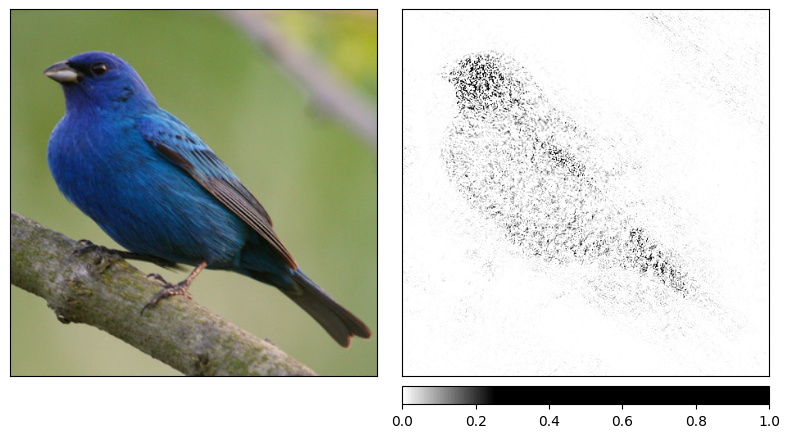

In [63]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## 2- Gradient-based attribution with noise tunnel

The second approach computes attributions using Integrated Gradients and smoothens them across multiple images generated by a <em>noise tunnel</em>. The latter adds gaussian noise to the input for 10 times (nt_samples=10). Lastly, noise tunnel smoothens the attributions across `nt_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `nt_samples` samples.

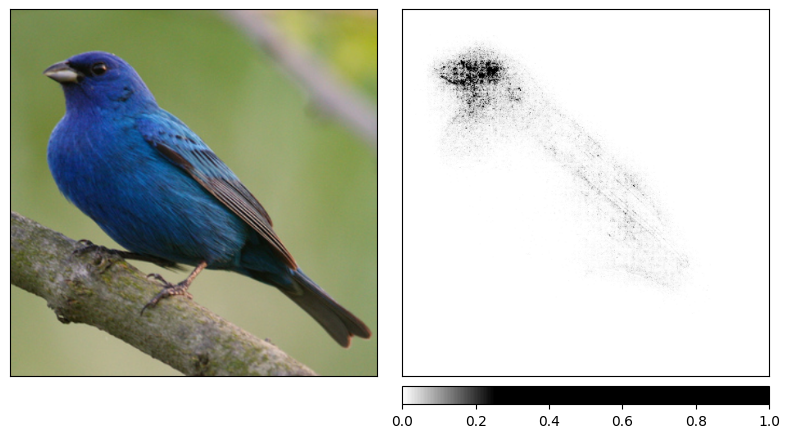

In [64]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


## 3- GradientShap
`GradientShap` is a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

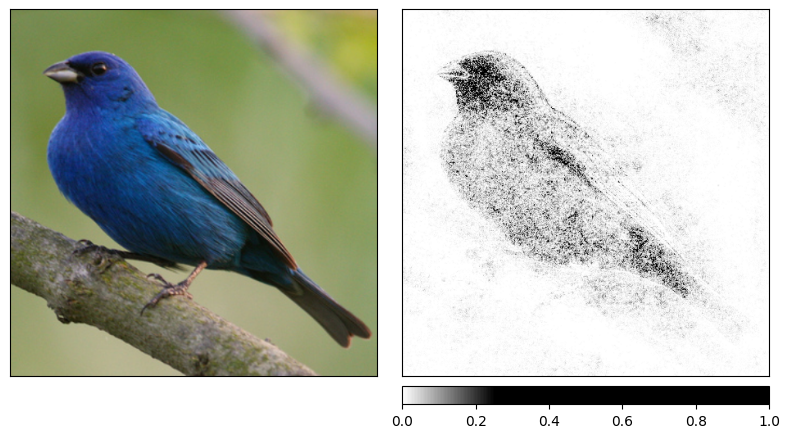

In [65]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

#defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


## 4- Occlusion-based attribution

Occlusion-based attribution can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

Occlusion-based attribution can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [66]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

It is possible to visualize the attributions focusing on the areas with positive attribution (those that are critical for the classifier's decision).

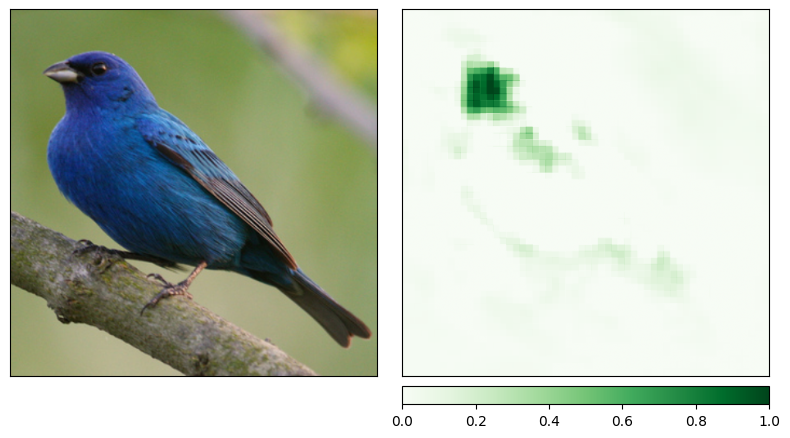

In [67]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)


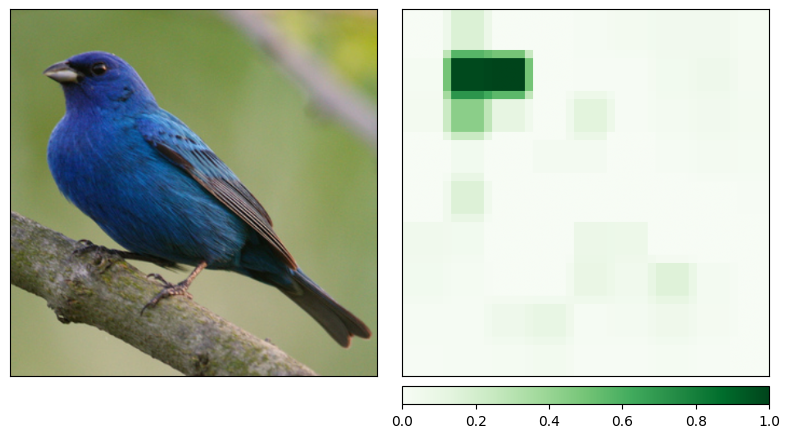

In [68]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

## 5- LIME 

Lastly, `LIME`, was taken from the Captum Library and modified, given that the CUB-200-2011 dataset does not provide segmentation masks, fundamental in the provided notebook. <br>
Lime aims to explain the local behavior of an example, it will reweight the training samples according to their similarity distances. By default, Captum's Lime uses the exponential kernel on top of the consine distance. Here, it will change to euclidean distance instead which is more popular in vision.

In [69]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lr_lime = Lime(
    model,
    interpretable_model=SkLearnLinearRegression(),  #built-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)

Modified the original approach which perturbated single pixels, in order to perturbate bigger regions.

Lime attribution:  25%|██▌       | 4/16 [00:10<00:31,  2.62s/it]

Lime attribution: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it]


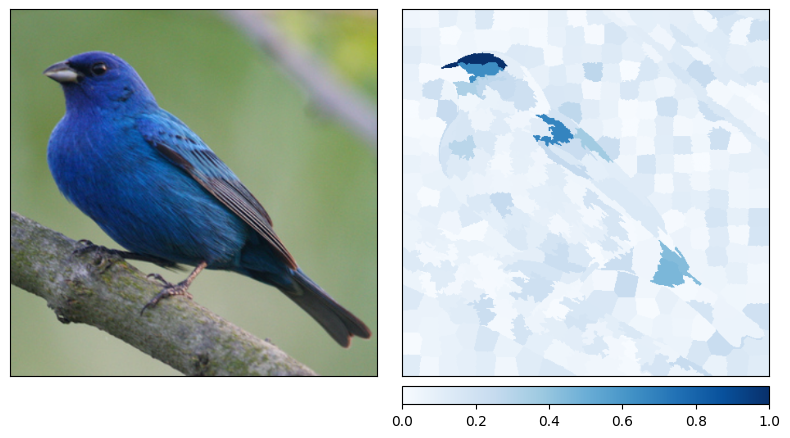

In [70]:

#convert image tensor to NumPy array for segmentation
image_np = input.squeeze(0).cpu().numpy()
image_np = np.transpose(image_np, (1, 2, 0))  #convert from (C, H, W) to (H, W, C)

#generate superpixels
num_segments = 400
feature_mask = slic(image_np, n_segments=num_segments, compactness=10)

#ensure feature mask starts from 0 
feature_mask = feature_mask - feature_mask.min()

#convert to tensor 
feature_mask = torch.tensor(feature_mask, device=input.device).unsqueeze(0)

#run LIME 
attrs = lr_lime.attribute(
    input,
    target=pred_label_idx,
    feature_mask=feature_mask,
    n_samples=500, 
    perturbations_per_eval=32,
    show_progress=True
).squeeze(0)

#ensure the original image is properly normalized to [0,1] for correct brightness
image_np = image_np - image_np.min()  #shift minimum to 0
image_np = image_np / image_np.max()  #scale max to 1


#use Captum's built-in visualization function to match previous models
_ = viz.visualize_image_attr_multiple(
    np.transpose(attrs.squeeze().cpu().detach().numpy(), (1,2,0)),  # Convert attribution map to (H, W, C)
    image_np, 
    methods=["original_image", "heat_map"],
    signs=["all", "absolute_value"], 
    show_colorbar=True,
    outlier_perc=1
)
